Welcome, solar physicists!  

In this notebook, you'll use Python, basic mathematics, and image analysis to analyse images of our Sun, including a special type of image called a "Dopplergram" that shows motion towards/away from us.  This will allow us to investigate the Sun's remarkable rotation.  

Follow the instructions in each section and fill in code where needed.



In [2]:
# --- Section 1: Setting the Stage ---

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image # Pillow library for image handling
import scipy.ndimage as ndi # For morphological operations (e.g., removing small features)
from skimage import measure # For contour finding (useful for sunspots)
from scipy.optimize import curve_fit # For fitting a curve to data

print("Libraries loaded successfully!")



Libraries loaded successfully!


In [5]:
# Task 1.1: Load the Solar Images
# We need two images: a visible light image and a Dopplergram.
# Make sure 'sun_visible.png' and 'sun_dopplergram.png' are in the same directory!

visible_image_path = 'sun_visible.png'
doppler_image_path = 'sun_dopplergram.png'

try:
    # Load visible light image (often grayscale or color)
    # We'll convert it to grayscale for simpler analysis later
    raw_visible_image = Image.open(visible_image_path).convert('L') # Convert to grayscale
    visible_data = np.array(raw_visible_image)

    # Load Dopplergram image (should be grayscale, where intensity = velocity)
    raw_doppler_image = Image.open(doppler_image_path).convert('L') # Convert to grayscale
    doppler_data = np.array(raw_doppler_image)

    print(f"Visible light image '{visible_image_path}' loaded successfully!")
    print(f"Dopplergram image '{doppler_image_path}' loaded successfully!")
    print(f"Image dimensions (both): {visible_data.shape[1]} x {visible_data.shape[0]} pixels")


    ################
    # YOUR CODE HERE: use imshow to display visible_data, using a grayscale colourmap:

    # give your plot a title and put in a colorbar:


    # Dopplergrams often show blue for approaching (blue-shifted) and red for receding (red-shifted).
    # Since our PNG is grayscale, we can use a diverging colourmap like 'RdBu' to visualize this.
    # We need to normalize the data to a specific range for the colormap.
    # Assuming 127 is zero velocity, 0 is max blue, 255 is max red.

    ################
    # YOUR CODE HERE: use imshow to display doppler_data using the RdBu colormap
    # Use the vmin=0,vmax=255 keywords, and give your plot a meaningful title
    # Include a colourbar
    


except FileNotFoundError:
    print(f"Error: One or both image files were not found.")
    print(f"Please ensure '{visible_image_path}' and '{doppler_image_path}' are in the same folder.")
    visible_data = None
    doppler_data = None
    
# Discussion Points:
# - What features do you see in the visible light image?
# - What do you think the colors/shades in the Dopplergram indicate? 
#   Look for a pattern that suggests rotation!

# Why do you think the intensity is strongest near the "limbs" of the Sun? 
# What effects other than rotation might affect the velocity towards/away from us?

Visible light image 'sun_visible.png' loaded successfully!
Dopplergram image 'sun_dopplergram.png' loaded successfully!
Image dimensions (both): 4096 x 4096 pixels



--- Section 2: Basic Image Properties and Statistics (Visible Light) ---


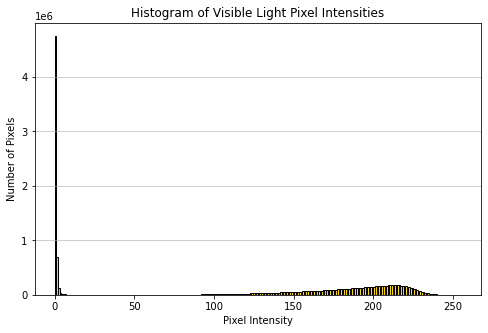

In [6]:

#Now let's do some basic statistics on the image, including a histogram of intensity values

if visible_data is not None:
    print("\n--- Section 2: Basic Image Properties and Statistics (Visible Light) ---")

    # Task 2.1-2.2: Find the Minimum,  Maximum, and Mean Pixel Intensities in Visible Light Image
    
    ################
    # YOUR CODE HERE: find the minimum, maximum, and mean values of the visible_data image, and print out the results

    #do the results make sense to you?

    # Task 2.3: Display a Histogram of Pixel Intensities
    plt.figure(figsize=(8, 5))
    plt.hist(visible_data.ravel(), bins=256, range=(0, 255), color='gold', edgecolor='black')
    plt.title("Histogram of Visible Light Pixel Intensities")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Number of Pixels")
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    # Discussion Point: What does the histogram tell you about the distribution of brightness?



--- Section 3: Feature Extraction - Finding Sunspots (Visible Light) ---
Sunspots are cooler, darker regions on the Sun's surface. Can we find them?
Found 21 potential sunspot regions.


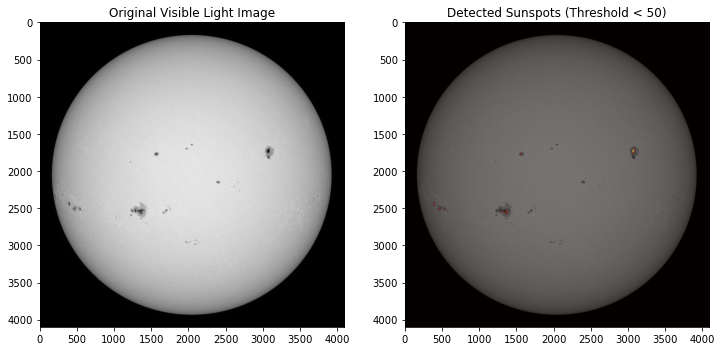

Total estimated sunspot area: 2248 pixels.
This is approximately 0.0134% of the total image area.


In [8]:
# --- Section 3: Feature Extraction - Finding Sunspots (Visible Light) ---

if visible_data is not None:
    print("\n--- Section 3: Feature Extraction - Finding Sunspots (Visible Light) ---")
    print("Sunspots are cooler, darker regions on the Sun's surface. Can we find them?")

    # Sunspots are typically darker than the surrounding photosphere.
    # We can use a simple intensity threshold to try and isolate them.
    
    ##################
    # Your code here: Adjust this threshold! (e.g., 50-100 for dark spots)
    sunspot_threshold = 50

    # Create a mask where pixels are darker than the threshold
    dark_pixels_mask = visible_data < sunspot_threshold

    # Could use morphological operations to clean up the mask, but for now skip this:
    # binary_opening removes small, isolated bright spots (noise).
    # binary_closing fills in small holes within dark regions.

    # If you have time, you can see what un-commenting these lines does to your selected spots
    #cleaned_mask = ndi.binary_opening(dark_pixels_mask, structure=np.ones((3,3))).astype(bool)
    #cleaned_mask = ndi.binary_closing(cleaned_mask, structure=np.ones((5,5))).astype(bool)
    cleaned_mask = dark_pixels_mask

    # Label connected regions to identify individual sunspots
    labeled_spots, num_features = ndi.label(cleaned_mask)
    print(f"Found {num_features} potential sunspot regions.")

    # Filter out very small regions that are likely noise
    min_spot_size = 50 # Minimum number of pixels for a region to be considered a sunspot
    max_spot_size = 10000 #maximum number of pixels in sunspot
    filtered_spots_mask = np.zeros_like(cleaned_mask)
    for i in range(1, num_features + 1): # Iterate through each labeled region
        spot_area = np.sum(labeled_spots == i)
        if (spot_area > min_spot_size) and (spot_area < max_spot_size) :
            filtered_spots_mask[labeled_spots == i] = True

    # Display the original image with an overlay of detected sunspots
    sunspot_overlay = np.zeros_like(visible_data, dtype=np.uint8)
    sunspot_overlay[filtered_spots_mask] = 255 # Highlight detected spots 

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(visible_data, cmap='gray')
    plt.title("Original Visible Light Image")

    plt.subplot(1, 2, 2)
    # We'll use the original image and overlay the mask for clarity
    plt.imshow(visible_data, cmap='gray')
    plt.imshow(filtered_spots_mask, cmap='hot', alpha=0.5) # Overlay with some transparency
    plt.title(f"Detected Sunspots (Threshold < {sunspot_threshold})")
    plt.show()

    # Task 3.1: Calculate the total area covered by sunspots
    total_sunspot_area_pixels = np.sum(filtered_spots_mask)
    print(f"Total estimated sunspot area: {total_sunspot_area_pixels} pixels.")
    print(f"This is approximately {total_sunspot_area_pixels / visible_data.size * 100:.4f}% of the total image area.")

    # Discussion Point:
    # - How does the sunspot threshold affect the number and size of detected spots?
    # - Why is it useful to filter out very small regions?
    # - If you take out the "max sunspot area" logic, what happens to the estimate of total sunspot area?  Why?
    # - How might you use this to track sunspot evolution over time?




--- Section 4: Advanced Optional: Solar Differential Rotation from Dopplergram ---
The Sun doesn't rotate like a solid body: some latitudes rotate faster than others.
This is called 'differential rotation'. We can see evidence of this in the Dopplergram.
Estimated Sun center: (2048, 2048), Radius: 2038 pixels.


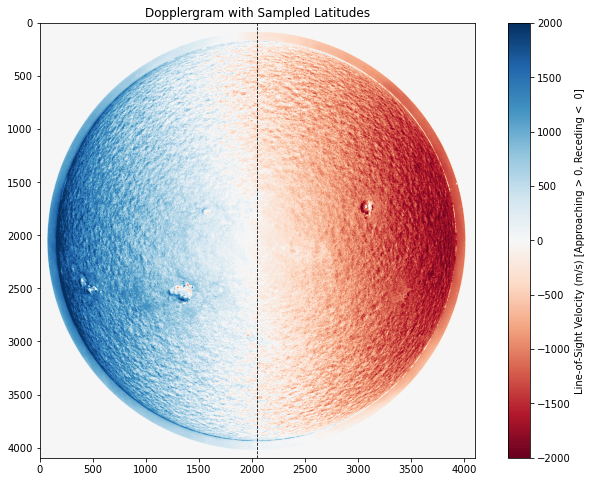

In [10]:
# --- Section 4: more advanced work: Solar Differential Rotation from Dopplergram ---

if doppler_data is not None:
    print("\n--- Section 4: Advanced Optional: Solar Differential Rotation from Dopplergram ---")
    print("The Sun doesn't rotate like a solid body: some latitudes rotate faster than others.")
    print("This is called 'differential rotation'. We can see evidence of this in the Dopplergram.")

    # In a Dopplergram, pixels with positive velocities (red) are moving away from us,
    # and pixels with negative velocities (blue) are moving towards us.
    # At the center of the Sun's disk (if there's no overall motion of the Sun relative to us),
    # the velocity should be zero (mid-gray).
    # The edges will show the fastest rotation, with one side approaching and the other receding.

    # We need to define the center and radius of the Sun in the image.
    # This assumes the Sun fills most of the image and is centered.
    img_height, img_width = doppler_data.shape
    center_x, center_y = img_width // 2, img_height // 2
    # Estimate radius by finding the brightest/darkest pixel near edge or using image size
    # A simple estimate is half the smallest dimension
    sun_radius = min(img_height, img_width) // 2 - 10 # Subtract a bit for safety

    print(f"Estimated Sun center: ({center_x}, {center_y}), Radius: {sun_radius} pixels.")

    # Convert pixel intensities to 'velocity' values.
    # Assuming 127 (mid-gray) is zero velocity.
    # Scale from 0-255 to approx -V_max to +V_max.
    # Let's assume a range like -2000 m/s to +2000 m/s for illustration (this depends on your data source)
    v_max_proxy = 2000 # Example maximum velocity in m/s for display/conceptual scaling
    doppler_velocity = ((doppler_data - 127.) / 127.0) * v_max_proxy # Simple linear scaling


    # Task 4.1: Extract Velocities Across Different Latitudes
    # We'll select a few horizontal slices (rows) at different 'latitudes' on the Sun's disk.
    # Each row corresponds to a certain latitude if the image is aligned.

    # Define some latitudes (rows) to sample
    # The 'latitude' here refers to the vertical position in the image.
    # Let's pick rows corresponding to roughly the equator, mid-latitudes, and near poles.
    # Row 0 is top, img_height-1 is bottom. Center_y is equator.
    lat_rows_pixels = [
        center_y, # Equator
        center_y - int(0.5 * sun_radius), # Mid-latitude North
        center_y + int(0.5 * sun_radius), # Mid-latitude South
        center_y - int(0.9 * sun_radius), # Near-pole North
        center_y + int(0.9 * sun_radius) # Near-pole South
    ]
    # Filter out rows outside image bounds
    lat_rows_pixels = [r for r in lat_rows_pixels if 0 <= r < img_height]

    plt.figure(figsize=(12, 8))
    plt.imshow(doppler_velocity, cmap='RdBu', vmin=-v_max_proxy, vmax=v_max_proxy)
    plt.title("Dopplergram with Sampled Latitudes")
    plt.colorbar(label='Line-of-Sight Velocity (m/s) [Approaching > 0, Receding <  0]')
    plt.axvline(x=center_x, color='black', linestyle='--', linewidth=0.8, label='Center of Sun')

    # Store profiles for plotting
    velocity_profiles = {}
   

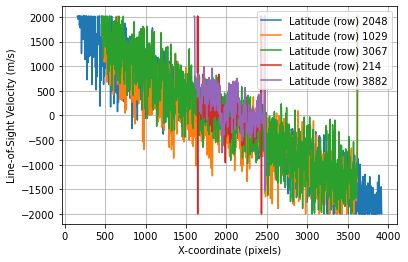

In [11]:
fig, ax=plt.subplots() # if you prefer to see them all together, use this outside the for loop


for i, row_idx in enumerate(lat_rows_pixels):
        # Extract the velocity data for this row
        velocity_slice = doppler_velocity[row_idx, :]


        # Identify pixels that are actually part of the Sun (within the disk)
        # We can use the visible light image as a simple mask for the solar disk.
        solar_disk_mask = (visible_data[row_idx, :] > 10) # Simple threshold for solar disk

        # Apply the mask to velocity_slice to only consider solar pixels
        x_coords_on_disk = np.arange(img_width)[solar_disk_mask]
        velocity_on_disk = velocity_slice[solar_disk_mask]
        

#        fig, ax=plt.subplots() # if you prefer to see them all separately, uncomment this line instead
        if len(x_coords_on_disk) > 0:
            # We expect approaching on one side, zero at center, receding on other side.
            ax.plot(x_coords_on_disk, velocity_on_disk, label=f'Latitude (row) {row_idx}')
            velocity_profiles[row_idx] = (x_coords_on_disk, velocity_on_disk)
        ax.set_xlabel("X-coordinate (pixels)")
        ax.set_ylabel("Line-of-Sight Velocity (m/s)")
        ax.legend()
        ax.grid(True)


#Discussion: try moving the "fig, ax=plt.subplots()"" command inside the for loop -- what happens?  why?
# What, physically, do these values mean?  Why might some latitudes show more variation than others?  


In [12]:
# Task 4.2: Fit a Sine Curve to Velocity Profiles (Conceptual)
# The line-of-sight velocity of a rotating sphere appears as a sine wave across its disk.
# v_los = V_rot * sin(theta), where theta is the angle from the central meridian.
# We'll simplify this: find the amplitude of the sine wave for each latitude.
# The amplitude corresponds to the rotational velocity at that latitude.

def sine_func(x, amplitude, offset):
    # A simple sine function for fitting
    # We expect velocity to go from negative to positive across the disk
    # We'll use a scaled x to represent angle across the disk
    # This is a very simplified model. A full model would include limb darkening, etc.
    # Here, x will be pixel coordinate. We need to map pixel x to an angle.
    # For simplicity, we just fit a sine curve to the raw pixel data and interpret amplitude.
    # X-coordinate from 0 to img_width will map to 0 to pi (or -pi/2 to pi/2)
    # We need to center the sine function on the x-coordinate of the Sun's center.
    phase = (x - center_x) / sun_radius * (np.pi/2) # Roughly map to -pi/2 to pi/2
    return amplitude * np.sin(phase) + offset

print("\nFitting sine curves to velocity profiles:")
latitude_rot_velocities = [] # Store (latitude_y_pixel, rotation_velocity_amplitude)

for row_idx, (x_coords, velocities) in velocity_profiles.items():
    if len(x_coords) > 10: # Ensure enough data points for fitting
        try:
            # Initial guess for amplitude (max_val - min_val / 2) and offset (mean)
            initial_amplitude = (np.max(velocities) - np.min(velocities)) / 2
            initial_offset = np.mean(velocities)
            ############
            ### YOUR CODE HERE:
            # write a 1-line command popt,pcov = (...) that uses curve_fit to fit the observed 
            # velocites and x-coords to a sine wave. Use keyword p0=[initial_amplitude, initial_offset]
            # 
            popt, pcov = None, None
            amplitude_fit, offset_fit = popt

            print(f"Row {row_idx}: Fitted Rotation Velocity (Amplitude) = {abs(amplitude_fit):.2f} m/s")
            latitude_rot_velocities.append((row_idx, abs(amplitude_fit)))

            # Plot the fit
            plt.figure(figsize=(8, 5))
            plt.plot(x_coords, velocities, 'o', label='Actual Velocities')
            plt.plot(x_coords, sine_func(x_coords, *popt), 'r-', label='Sine Fit')
            plt.title(f"Velocity Profile and Fit for Row {row_idx}")
            plt.xlabel("X-coordinate (pixels)")
            plt.ylabel("Line-of-Sight Velocity (m/s)")
            plt.legend()
            plt.grid(True)
            plt.show()

        except RuntimeError:
            print(f"Could not fit curve for row {row_idx}. Not enough variation or data points.")
    else:
        print(f"Skipping fit for row {row_idx}: Not enough data points on disk.")




Fitting sine curves to velocity profiles:


TypeError: cannot unpack non-iterable NoneType object

In [13]:
# Task 4.3: Plot Rotation Velocity vs. Latitude
# This is the key plot demonstrating differential rotation!
if len(latitude_rot_velocities) > 1:
    # Sort by latitude (row_idx) for clear plotting
    latitude_rot_velocities.sort(key=lambda x: x[0])
    latitudes = np.array([item[0] for item in latitude_rot_velocities])
    rot_velocities = np.array([item[1] for item in latitude_rot_velocities])

    # Convert pixel latitude to a more intuitive scale if possible (e.g., fractional radius)
    # 0 is equator, positive is North, negative is South
    relative_latitudes = (latitudes - center_y) / sun_radius

    plt.figure(figsize=(8, 6))
    
    #######
    #### YOUR CODE HERE
    # plot rot_velocities as a function of relative_latitudes
    
    
    # Discussion Point:
    # - What does this plot tell you about the Sun's rotation?
    # - Which regions rotate fastest? Slowest?
    # - How does this differ from the rotation of a solid object like Earth?
    # - Why do you think the Sun exhibits differential rotation? 
    
# --- Section 5: Conclusion and Further Exploration ---

print("\n--- Section 5: Conclusion and Further Exploration ---")

print("Congratulations! You've analyzed our Sun's visible features and investigated its differential rotation using Dopplergram data.")
print("You've applied image processing, statistics, and even curve fitting using Python to learn something neat!")    


--- Section 5: Conclusion and Further Exploration ---
Congratulations! You've analyzed our Sun's visible features and investigated its differential rotation using Dopplergram data.
You've applied image processing, statistics, and even curve fitting using Python to learn something neat!



--- Section 5: Bonus Activity: Principal Component Analysis (PCA) for Image Compression ---
PCA is a powerful mathematical technique used to reduce the 'dimensionality' of data.
For images, it can help us find the most important patterns that capture most of the image's information,
which is useful for compression and noise reduction.


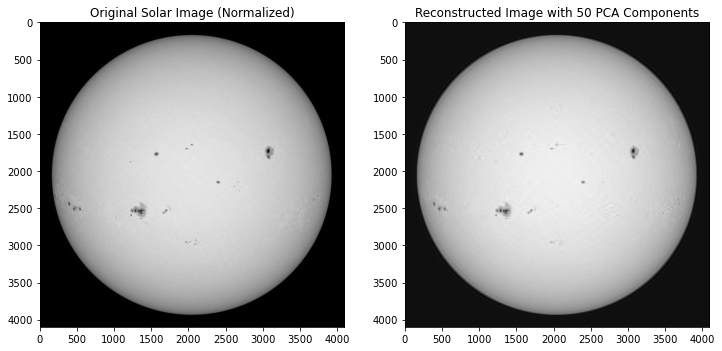

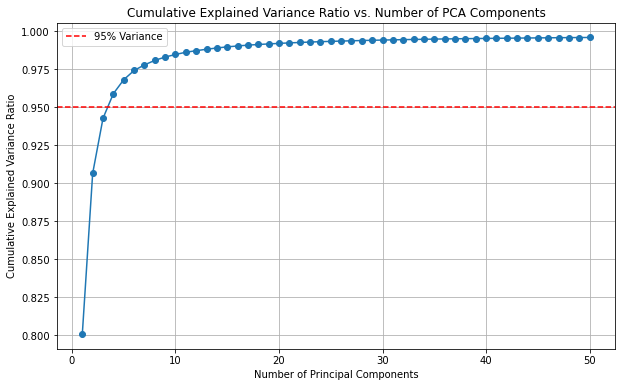

With 50 components, we explain 99.59% of the variance.


In [14]:
# Bonus: PCA

from sklearn.decomposition import PCA # Sci-kit Learn for PCA 

if visible_data is not None:
    print("\n--- Section 5: Bonus Activity: Principal Component Analysis (PCA) for Image Compression ---")
    print("PCA is a powerful mathematical technique used to reduce the 'dimensionality' of data.")
    print("For images, it can help us find the most important patterns that capture most of the image's information,")
    print("which is useful for compression and noise reduction.")

    # PCA works best on 2D data (rows as samples, columns as features).
    # An image is a 2D array. We'll treat each row as a 'sample' and each pixel in that row as a 'feature'.
    # Normalize the image data to be between 0 and 1, which is often good practice for PCA.
    normalized_visible_data = visible_data / 255.0

    # Task 5.1: Perform PCA on the image data
    # We will specify the number of components (n_components) to keep.
    # Each component represents a 'mode' or 'pattern' in the image data.

    # Try starting with a small number of components
    # The smaller the number, the more compression, but potentially less detail.
    n_components_pca = 50 # You can experiment with this number!

    # Your code here: Initialize PCA and fit it to the normalized image data.
    # The 'fit' step calculates the principal components.
    pca_solar = PCA(n_components=n_components_pca)
    pca_solar.fit(normalized_visible_data)

    # Now, transform the original data into the new PCA space (reduced dimensionality).
    reduced_solar_data = pca_solar.transform(normalized_visible_data)

    # And then, reconstruct the image using only these principal components.
    # This shows how much information is retained.
    reconstructed_solar_image = pca_solar.inverse_transform(reduced_solar_data)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(normalized_visible_data, cmap='gray')
    plt.title("Original Solar Image (Normalized)")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_solar_image, cmap='gray')
    plt.title(f"Reconstructed Image with {n_components_pca} PCA Components")
    plt.show()

    # Task 5.2: Analyze the Explained Variance Ratio
    # The 'explained_variance_ratio_' tells us how much of the original image's
    # variability (information) is captured by each principal component.
    # We can plot the cumulative sum to see how much total information we retain.

    explained_variance_ratio_solar = pca_solar.explained_variance_ratio_
    cumulative_variance_ratio_solar = np.cumsum(explained_variance_ratio_solar)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance_ratio_solar) + 1), cumulative_variance_ratio_solar, marker='o', linestyle='-')
    plt.title("Cumulative Explained Variance Ratio vs. Number of PCA Components")
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance Ratio")
    plt.grid(True)
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
    plt.legend()
    plt.show()

    print(f"With {n_components_pca} components, we explain {cumulative_variance_ratio_solar[-1]*100:.2f}% of the variance.")

    # Discussion Point:
    # 1. Look at the reconstructed image. How well does it resemble the original?
    # 2. Look at the cumulative explained variance plot. How many components would you need
    #    to capture, say, 90% or 95% of the information in the image?
    # 3. Why is PCA useful for tasks like image compression or noise reduction? (Hint: It focuses on essential patterns).
    # 4. How might PCA be used in actual solar physics research (e.g., classifying active regions, detecting subtle changes)?

